<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Inverse_BlackScholes_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Analytic formula

In [ ]:
def black_scholes(S, t, T=1.0, K=120, r=0.05, sigma=0.20, option_type="call"):
    """
    Compute the Black-Scholes option price.

    Args:
        S (torch.Tensor): Current stock price.
        T (float): Time to maturity.
        t (float): Current time (typically 0).
        K (float): Strike price.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the stock price.
        option_type (str): "call" or "put".

    Returns:
        torch.Tensor: Option price.
    """
    # Ensure inputs are PyTorch tensors and have the correct dtype
    S = S.type(torch.float32) # Changed to type casting

    # Time to maturity
    tau = T - t

    # Avoid division by zero for tau = 0
    epsilon = 1e-8

    # Convert r and tau to tensors
    r = torch.tensor(r, dtype=torch.float32)
    tau = torch.tensor(tau, dtype=torch.float32)

    # Compute d1 and d2
    # Use tau and epsilon directly for torch.sqrt, no need to create new tensors
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau + epsilon))
    d2 = d1 - sigma * torch.sqrt(tau + epsilon)

    # Compute N(d1) and N(d2) using the cumulative distribution function
    N_d1 = 0.5 * (1.0 + torch.erf(d1 / torch.sqrt(torch.tensor(2.0))))
    N_d2 = 0.5 * (1.0 + torch.erf(d2 / torch.sqrt(torch.tensor(2.0))))

    # Compute the call or put price
    if option_type == "call":
        option_price = S * N_d1 - K * torch.exp(-r * tau) * N_d2
    elif option_type == "put":
        option_price = K * torch.exp(-r * tau) * (1.0 - N_d2) - S * (1.0 - N_d1)
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    return option_price

In [ ]:
def bs_pde_residual(model, S, t, r=0.05, sigma=0.20):
    """
    Compute the PDE residual for Black-Scholes equation:
    """
    S.requires_grad = True
    t.requires_grad = True
    V = model(torch.cat((S, t), dim=1))

    # Gradients w.r.t. x and t
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. S
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5*sigma**2*S**2*V_SS + r*S*V_S -r*V
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (S, t)
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)  # Output: V(S, t)
        )

    def forward(self, s):
        return self.hidden_layers(s)

# Step 3: Define the loss function
def compute_loss(model, S_interior, t_interior,
                 S_boundary, t_boundary, V_boundary,
                 S_initial, t_initial, V_initial,
                 r, sigma, epoch=0):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = bs_pde_residual(model, S_interior, t_interior, r, sigma)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss:
    # V(0, t)=0
    # V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞

    V_boundary_low_pred = model(torch.cat((S_boundary[0], t_boundary), dim=1))
    V_boundary_high_pred = model(torch.cat((S_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean((V_boundary_low_pred - V_boundary[0])**2) + \
              torch.mean((V_boundary_high_pred - V_boundary[1])**2)


    # Initial condition loss:
    # (at 𝑡=𝑇): 𝑉(𝑆,𝑇)=max(𝑆−𝐾,0)
    V_initial_pred = model(torch.cat((S_initial, t_initial), dim=1))
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    if epoch % 100 == 0:
      print(f"Adam Epoch {epoch}, PDE Loss: {pde_loss.item()}, BC Loss: {bc_loss.item()}, IC Loss: {ic_loss.item()}")

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, S_interior, t_interior,
               S_boundary, t_boundary, V_boundary,
               S_initial, t_initial, V_initial,
               r, sigma, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial,
                            r, sigma, epoch)
        loss.backward()
        optimizer_adam.step()

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    lbfgs_iter = 0
    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial, r, sigma, 1)
        loss.backward()
        if lbfgs_iter % 100 == 0:
            print(f"LBFGS Iteration {lbfgs_iter}, Loss: {loss.item()}")
        lbfgs_iter += 1

        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [ ]:
# Underlying asset and time are normalized BUT not option Values
S_max = 150.0
S_min = 50.0
K = 100.0
T = 5.0
r = 0.05
sigma = 0.2

S = torch.linspace(S_min, S_max, 100).view(-1, 1)
# Normalize S
S_norm = (S - S_min) / (S_max - S_min)
t = torch.linspace(0, T, 100).view(-1, 1)
t_norm = (t - 0) / (T - 0)

# Create mesh grid for interior points
S_grid, t_grid = torch.meshgrid(S_norm.squeeze(), S_norm.squeeze(), indexing='ij')
S_interior = S_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
# V(0, t)=0
# V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
t_boundary = S_norm
S_boundary = [torch.full_like(t, 0), torch.full_like(t, 1.0)]
V_boundary = [torch.full_like(t, 0), S_max - K * torch.exp(-r * (T - t))]


# Initial points
# (at 𝑡=𝑇): 𝑉(𝑆, 𝑇)=max(𝑆−𝐾, 0)
S_initial = S_norm
t_initial = torch.full_like(t, 1.0)
V_initial = torch.maximum(S - K, torch.tensor(0.0))

In [ ]:
t.shape, S_initial.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [ ]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_interior, t_interior, S_boundary, t_boundary, V_boundary,
           S_initial, t_initial, V_initial, r, sigma,
           adam_epochs=1000, lbfgs_epochs=500)

Adam Epoch 0, PDE Loss: 0.00017336109885945916, BC Loss: 3819.70947265625, IC Loss: 423.7772521972656
Adam Epoch 100, PDE Loss: 5.26291561126709, BC Loss: 905.4842529296875, IC Loss: 390.7003173828125
Adam Epoch 200, PDE Loss: 53.30612564086914, BC Loss: 48.77751922607422, IC Loss: 98.17755889892578
Adam Epoch 300, PDE Loss: 37.16982650756836, BC Loss: 36.56987380981445, IC Loss: 49.76451110839844
Adam Epoch 400, PDE Loss: 17.862760543823242, BC Loss: 21.46318817138672, IC Loss: 12.481453895568848
Adam Epoch 500, PDE Loss: 11.379258155822754, BC Loss: 14.965095520019531, IC Loss: 4.795386791229248
Adam Epoch 600, PDE Loss: 9.587620735168457, BC Loss: 12.979405403137207, IC Loss: 2.9503204822540283
Adam Epoch 700, PDE Loss: 8.81550121307373, BC Loss: 10.860984802246094, IC Loss: 1.8949182033538818
Adam Epoch 800, PDE Loss: 8.245073318481445, BC Loss: 8.948661804199219, IC Loss: 1.2171168327331543
Adam Epoch 900, PDE Loss: 7.669442176818848, BC Loss: 7.377870559692383, IC Loss: 0.8059237

In [ ]:
#torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True, precision=6)

# Step 7: Visualize the results
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
S_pred_norm = (S_pred - S_min) / (S_max - S_min)

t_pred = torch.linspace(0, T, 100).view(-1, 1)
t_pred_norm = (t_pred - 0) / (T - 0)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred_norm.squeeze(), t_pred_norm.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    V_pred = model(torch.cat((S_flat, t_flat), dim=1)).detach().numpy()

V_pred = V_pred.reshape(100, 100)
print(V_pred)


# black_scholes(S, t, T, K, r, sigma)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)
V_exact = black_scholes(S_flat, t_flat, T, K, r, sigma)
V_exact = V_exact.reshape(100, 100)
print(V_exact.detach().numpy())

[[-0.002799 -0.002721 -0.002639 ...  0.00063   0.000653  0.00068 ]
 [-0.002257 -0.002173 -0.002099 ...  0.001174  0.001153  0.001201]
 [-0.001779 -0.001685 -0.00159  ...  0.00166   0.001672  0.001706]
 ...
 [62.330196 62.106743 61.883286 ... 48.029755 48.00509  47.980442]
 [67.451294 67.227844 67.00438  ... 49.034256 49.01015  48.98604 ]
 [72.572395 72.34893  72.12547  ... 50.89716  50.673702 50.450245]]
[[ 2.328528  2.273104  2.218119 ...  0.        0.        0.      ]
 [ 2.559029  2.500034  2.441475 ...  0.        0.        0.      ]
 [ 2.803271  2.740661  2.678473 ...  0.        0.        0.      ]
 ...
 [71.698784 71.49028  71.28107  ... 48.483574 48.232002 47.979797]
 [72.66059  72.45214  72.24301  ... 49.493675 49.242104 48.9899  ]
 [73.62392  73.41553  73.20644  ... 50.503777 50.252205 50.      ]]


<ipython-input-2-57165c588757>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float32)


In [ ]:
V_pred.shape, V_pred[:, 99]

((100, 100),
 array([ 0.00068 ,  0.001201,  0.001706,  0.002154,  0.002278,  0.00241 ,
         0.00254 ,  0.002677,  0.002791,  0.00291 ,  0.003038,  0.003182,
         0.003295,  0.003448,  0.003541,  0.003688,  0.003833,  0.003955,
         0.004077,  0.004153,  0.004243,  0.00418 ,  0.002996,  0.001842,
         0.000682, -0.000497, -0.001668, -0.002833, -0.003995, -0.005155,
        -0.006343,  0.00485 ,  0.016786,  0.007318, -0.012338, -0.015475,
         0.000882,  0.002694,  0.000419, -0.000573, -0.001607,  0.007958,
        -0.000554, -0.001515, -0.002482, -0.003449, -0.004405, -0.005344,
        -0.006324,  0.013861,  0.532509,  1.499911,  2.508992,  3.569343,
         4.562093,  5.554827,  6.547564,  7.540308,  8.592658,  9.593629,
        10.60488 , 11.616917, 12.628963, 13.641006, 14.653056, 15.665102,
        16.670033, 17.67876 , 18.687494, 19.69623 , 20.704977, 21.713692,
        22.722445, 23.734247, 24.744623, 25.75501 , 26.765406, 27.775785,
        28.78617 , 29.796

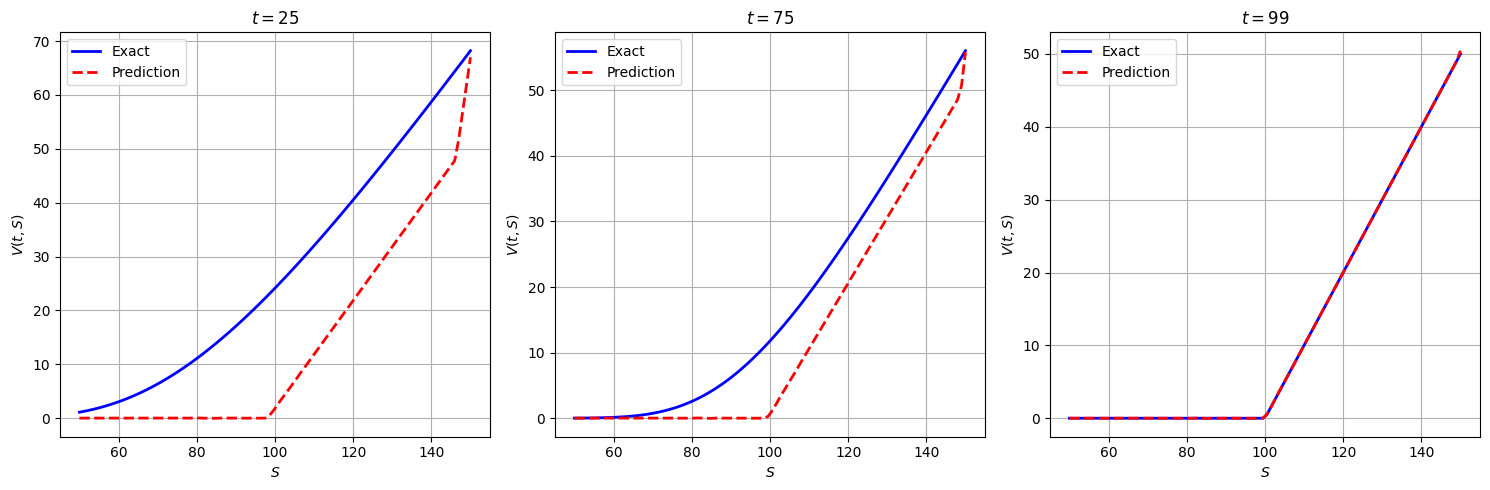

In [ ]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(S_pred.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(S_pred.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$S$")
    plt.ylabel("$V(t, S)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


<ipython-input-23-394df1bf8c0b>:9: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


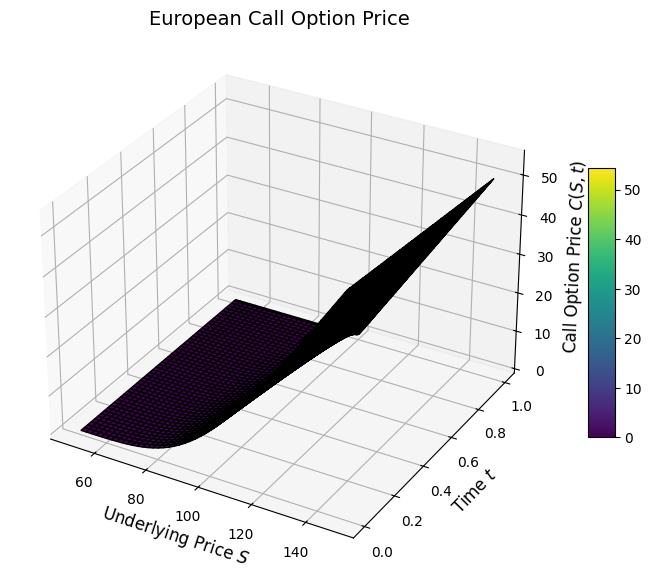

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula
def black_scholes_call(S, K, T, t, r, sigma):
    """Compute the European call option price."""
    tau = T - t  # Time to maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Asset prices and time grid
S = np.linspace(50, 150, 100)  # Asset price range
t = np.linspace(0, T, 100)     # Time range

# Create mesh grid
S_grid, t_grid = np.meshgrid(S, t)

# Compute call option prices
call_prices = black_scholes_call(S_grid, K, T, t_grid, r, sigma)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(S_grid, t_grid, call_prices, cmap='viridis', edgecolor='k')
ax.set_title("European Call Option Price", fontsize=14)
ax.set_xlabel("Underlying Price $S$", fontsize=12)
ax.set_ylabel("Time $t$", fontsize=12)
ax.set_zlabel("Call Option Price $C(S,t)$", fontsize=12)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


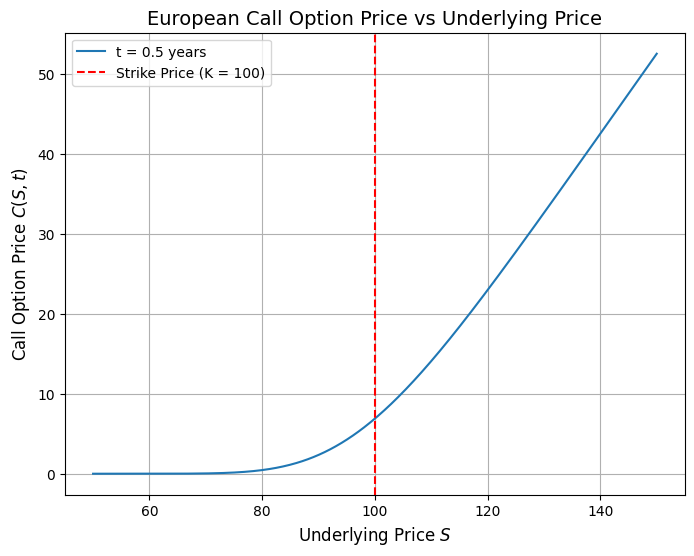

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula
def black_scholes_call(S, K, T, t, r, sigma):
    """Compute the European call option price."""
    tau = T - t  # Time to maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity (in years)
t = 0.5  # Current time (6 months before maturity)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Asset prices
S = np.linspace(50, 150, 500)  # Asset price range

# Compute call option prices
call_prices = black_scholes_call(S, K, T, t, r, sigma)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(S, call_prices, label=f"t = {t} years")
plt.axvline(K, color='r', linestyle='--', label=f"Strike Price (K = {K})")
plt.title("European Call Option Price vs Underlying Price", fontsize=14)
plt.xlabel("Underlying Price $S$", fontsize=12)
plt.ylabel("Call Option Price $C(S,t)$", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


<ipython-input-24-2859add72350>:9: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


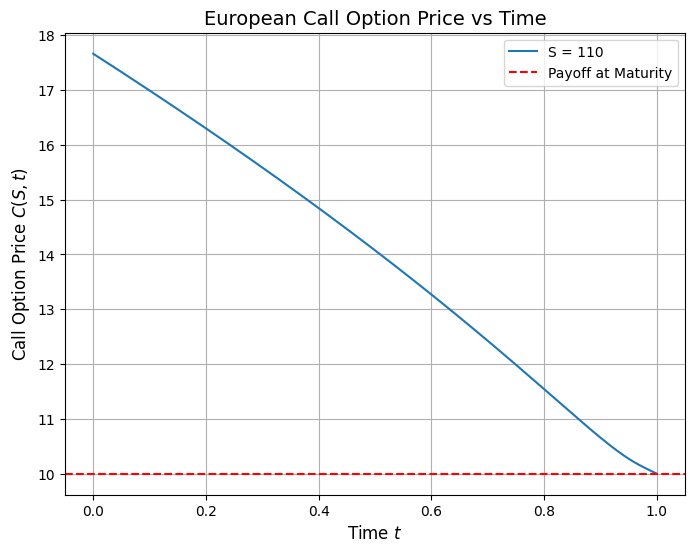

In [ ]:
# Fixed parameters
S = 110  # Current stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Time grid
t = np.linspace(0, T, 500)  # Time to maturity

# Compute call option prices
call_prices = black_scholes_call(S, K, T, t, r, sigma)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, call_prices, label=f"S = {S}")
plt.axhline(max(S - K, 0), color='r', linestyle='--', label="Payoff at Maturity")
plt.title("European Call Option Price vs Time", fontsize=14)
plt.xlabel("Time $t$", fontsize=12)
plt.ylabel("Call Option Price $C(S,t)$", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
